In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.data as skdata
from project.algorithms.simulation import dummy_object, ptychogram_shift, illumination_beam
from project.algorithms.utils import circ_aperture, normalize, ft, ift, frashift
from project.tests.test_shift import TransRefinement1
from project.algorithms.reconstruction import update_obj, update_probe, TransRefinement

In [2]:
# Turn off for white background/jupyter notebook
background_dark = True
if background_dark:
    plt.style.use('dark_background')

In [3]:
"ground truth"
intensity = np.array(plt.imread('lena.tif'))
phase = skdata.camera()
obj = dummy_object(intensity=intensity, phase=phase, output_shape=(256, 256))
box_shape = (161, 161)   # the size of reconstruction box
r = 0.5
illumination = illumination_beam(box_shape, beam_radius=r)
illumination = normalize(illumination)

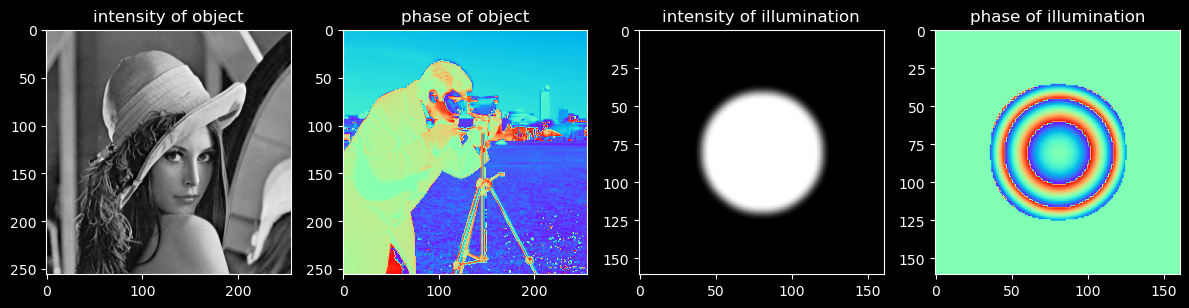

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(np.abs(obj), cmap='gray')
axes[0].set_title('intensity of object')
axes[1].imshow(np.angle(obj), cmap='rainbow')
axes[1].set_title('phase of object')
axes[2].imshow(np.abs(illumination), cmap='gray')
axes[2].set_title('intensity of illumination')
axes[3].imshow(np.angle(illumination), cmap='rainbow')
axes[3].set_title('phase of illumination')
plt.tight_layout()

In [37]:
"positions and ptychogram"
positions = np.load('positions.npy').astype('float')
patterns = []
for position in positions:
    pattern = ptychogram_shift(obj, illumination, position)
    patterns.append(pattern)

In [38]:
"initial estimation and parameter"
guess_probe = circ_aperture(box_shape, radius=0.4).astype('complex')
# guess_probe = illumination
guess_obj = np.ones(obj.shape, dtype="complex")
# guess_positions = np.load('ini_guess.npy').astype('float')
guess_positions = positions.copy()
num_IPs = 49
IPs = np.random.choice(49, num_IPs)
max_error = 8
x_error = np.random.uniform(0, 1, num_IPs) * max_error
y_error = np.random.uniform(0, 1, num_IPs) * max_error
guess_positions[IPs,0] += y_error
guess_positions[IPs,1] += x_error
a, b = 1., 1.

In [39]:
(K, L) = guess_probe.shape
(M, N) = guess_obj.shape
sy, sx, sx1, sy1 = [], [], [], []
beta = [50, 50]

for n in range(200):
    index = np.random.choice(49, 49)
    for i in index:
    # for i in range(49):
        x = guess_positions[i][1]
        y = guess_positions[i][0]
        pattern = patterns[i]
        shift = -np.array([y - M//2, x - N//2]).astype('float')
        guess_obj = frashift(guess_obj, shift)
        obj_scanned = guess_obj[M//2 -K//2 : M//2+K//2+1, N//2-L//2 : N//2+L//2+1]

        "revise the wave function in diffraction plane"
        psi = obj_scanned * guess_probe
        Psi = ft(psi)
        phase_Psi = np.exp(1j * np.angle(Psi))
        Psi_corrected = np.sqrt(pattern) * phase_Psi
        psi_corrected = ift(Psi_corrected)

        "update the object and probe functions"
        diff_psi = psi_corrected - psi
        temp_obj = obj_scanned.copy()
        obj_scanned = update_obj(obj_scanned, guess_probe, diff_psi, learning_rate=a)
        guess_obj[M//2 -K//2 : M//2+K//2+1, N//2-L//2 : N//2+L//2+1] = obj_scanned
        guess_obj = frashift(guess_obj, -shift)
        guess_probe = update_probe(guess_probe, temp_obj, diff_psi, learning_rate=b)


        if i in IPs:
            syj, sxj = TransRefinement(obj_scanned, temp_obj, integer_skip=False)
            if n >= 5:
                dy, dx = syj * beta[0], sxj * beta[1]
                y -= dy
                x -= dx
                guess_positions[i] = np.array([y, x])
        #     sy.append(syj)
        #     sx.append(sxj)
            # syj1, sxj1 = TransRefinement1(obj_scanned, temp_obj, integer_skip=False)
            # sx1.append(sxj1)
            # sy1.append(syj1)
    # if n >= 20:
    #     # syj, sxj = TransRefinement(obj_scanned, temp_obj, integer_skip=False)
    #     x = guess_positions[25][1]
    #     y = guess_positions[25][0]
    #     dy, dx = syj * beta[0], sxj * beta[1]
    #     y -= dy
    #     x -= dx
    #     guess_positions[25] = np.array([y, x])

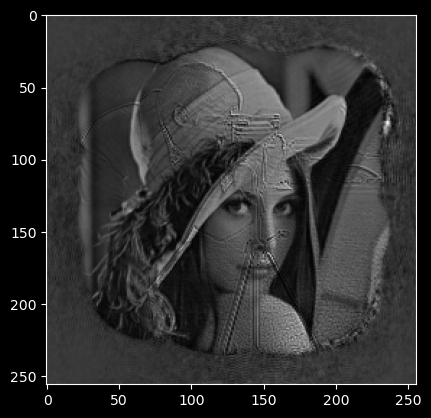

In [40]:
plt.imshow(np.abs(guess_obj), cmap='gray')

In [41]:
np.max(np.abs(positions-guess_positions))

0.3189514508472229

In [42]:
positions-guess_positions

array([[-8.48236305e-02, -5.63531458e-02],
       [-5.56877310e-02, -5.47769319e-02],
       [-1.36377587e-02, -1.97855758e-02],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.56422814e-02,  2.89141563e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [-5.04593755e-02,  2.89334531e-02],
       [-3.83661896e-02, -2.55681438e-02],
       [-1.98780286e-02, -1.32666094e-02],
       [ 2.85677891e-03, -1.96541781e-02],
       [ 4.30272946e-03, -4.71352250e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-3.18951451e-01,  2.36859344e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.41032645e-02, -1.33203297e-02],
       [-1.05827132e-02, -1.24744184e-02],
       [ 2.04022069e-02, -2.22642753e-02],
       [ 2.13675746e-02, -1.60712306e-02],
       [ 1.35338240e-01, -9.04398497e-02],
       [ 1.99659535e-01, -1.83350331e-01],
       [-2.